# Class Notes

## Multicolinearity in Linear Regression

<img src="images/lines.jpg" width=50%>

<p style="text-align:left;">
    <a href="https://www.pexels.com/photo/marketing-businessman-person-hands-6801872/">Photo by Anna Nekrashevich from Pexels</a>
    <span style="float:right;">
        May 19, 2022 <br>
        Firas Moosvi
    </span>
</p>



In [9]:
# Adjust plot aspect ratio and apperance
library(repr)
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 400)

library("tidyverse")
library("moderndive")

suppressPackageStartupMessages({
  library("janitor")
  library("car")
  library("corrplot")
  library("ISLR")
  library("plotly")
  library("cowplot")
  library("GGally")
})

# Only display 10 rows of tibble
repr_html.tbl_df <- function(obj, ..., rows = 10) repr:::repr_html.data.frame(obj, ..., rows = rows)

# ggplot theme
theme <- list(
  theme_bw(),
  scale_color_brewer(palette = "Dark2"),
  theme(legend.position = "none")
)

# fit summary
fit_summary <- function(model) {
  tb <- broom::glance(model)[c("r.squared", "nobs", "statistic")]
  tb <- tb |>
    add_column(r = sqrt(tb$r.squared), .before = "r.squared") |>
    rename(`R^2` = r.squared, R = r)
  return(round(tb, 3))
}

# `Credit` dataset
data <- Credit |>
  as_tibble() |>
  clean_names() |>
  rename(debt = balance) |>
  mutate(income = income * 1000)

# Overwrite

regression_table <- function(model) {
  return(get_regression_table(model)[c("term", "estimate", "statistic")] |> rename(beta = estimate))
}

## Learning Context (3 mins)

<img src="images/avatars.jpg" width=50% align="center">

### Academic program:

- Block 3 of the UBC Master of Data Science (MDS) program
- One of 4 concurrent courses students are taking
- ~ 120 students in the program

### Course Details

- DSCI 561 - Regression I
- **Course Prerequisite**:
    - DSCI 552 - Statistical Inference and Computation I
- **Content Prerequisite**:
    - Class 5 of 8 in DSCI 561
    - Students have already done simple linear regression, inference vs. prediction, coefficient estimation, parameter interpretation, Pearson's correlation, and understanding output of regression using the `broom()` package
- Core course, required for several follow-up courses
- It's relatively early in the program, almost everyone in here wants to be here and is excited to learn more!

### Programming Experience

- Least experienced: Two blocks of working in Python and R sporadically
- Most experienced:  Worked in software industry for 2+ years

### Learning Intentions

After deliberate **review** of this lesson, consideration of supplementary content, and sufficient **practice**, I intend for students to be able to:

- Implement a simple linear regression, and a multiple linear regression in the R programming language.

- Develop some *intuition* about the correlation ($R$), and assess whether there is collinearity between two variables.

- Evaluate the stability of a linear regression model with and without collinearity.

- Use the Variable Inflation Factor (VIF) to determine whether multicollinearity exists in a regression analysis.

- Critically examine strategies for resolving multicollinearity in regression analyses (**focus of this lab**).

### Structure of my "Teaching Practice" and "Teaching Strategy" talk

- My classes and lessons use a **lot** of active learning techniques.

- In my experience, reproducing that experience in interview talks is not that successful and often feels forced and uncomfortable, despite how willing the participants are!

- So instead, I will do an **annotated teaching talk** and interleave discussion about my teaching strategy in my teaching practice simulation.
    - I usually give students some time to do some activities and work in small groups ; today, instead of asking you to do those activities, I'll use that time to justify and rationalize my teaching choices.

- For you, nothing will change except that you'll need to use your imagination and pretend that while we're having the meta discussion, students would be busy working on specific tasks.
    - Feel free to interrupt any time to ask questions about my teaching practice, or to ask about the content as a student.

- I expect this combined section will take about 45 minutes + ~ 5 minutes on "Assessments" at the end.

## Recap: `Credit` dataset and Multiple Linear Regression (10 mins)

### Reminder: `Credit` dataset

| Variable    | Range (Unit) | Description                      |
|-------------|--------------|----------------------------------|
| `debt`      | (\$)         | Average credit card debt         |
| `income`    | (\$)         | Total Income                     |
| `limit`     | (\$)         | Credit Limit                     |
| `rating`    | 0-1000       | Credit Rating                    |
| `cards`     | 2 - 9        | Number of Credit Cards           |
| `age`       | 23 - 98      | Age of individual                |
| `education` | 5 - 20       | Years of Education               |
| `gender`    | -            | Male/Female                      |
| `ethnicity` | -            | Caucasian/Asian/African American |
| `student`   | -            | Yes/No                           |
| `married`   | -            | Yes/No                           |

Reference: [An introduction to statistical learning with applications in R. by Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani.](https://www.statlearning.com)

### Linear Regression: credit `debt` regressed on `income`

> $\hat{debt} = \beta_0 + \beta_1\textrm{income}$

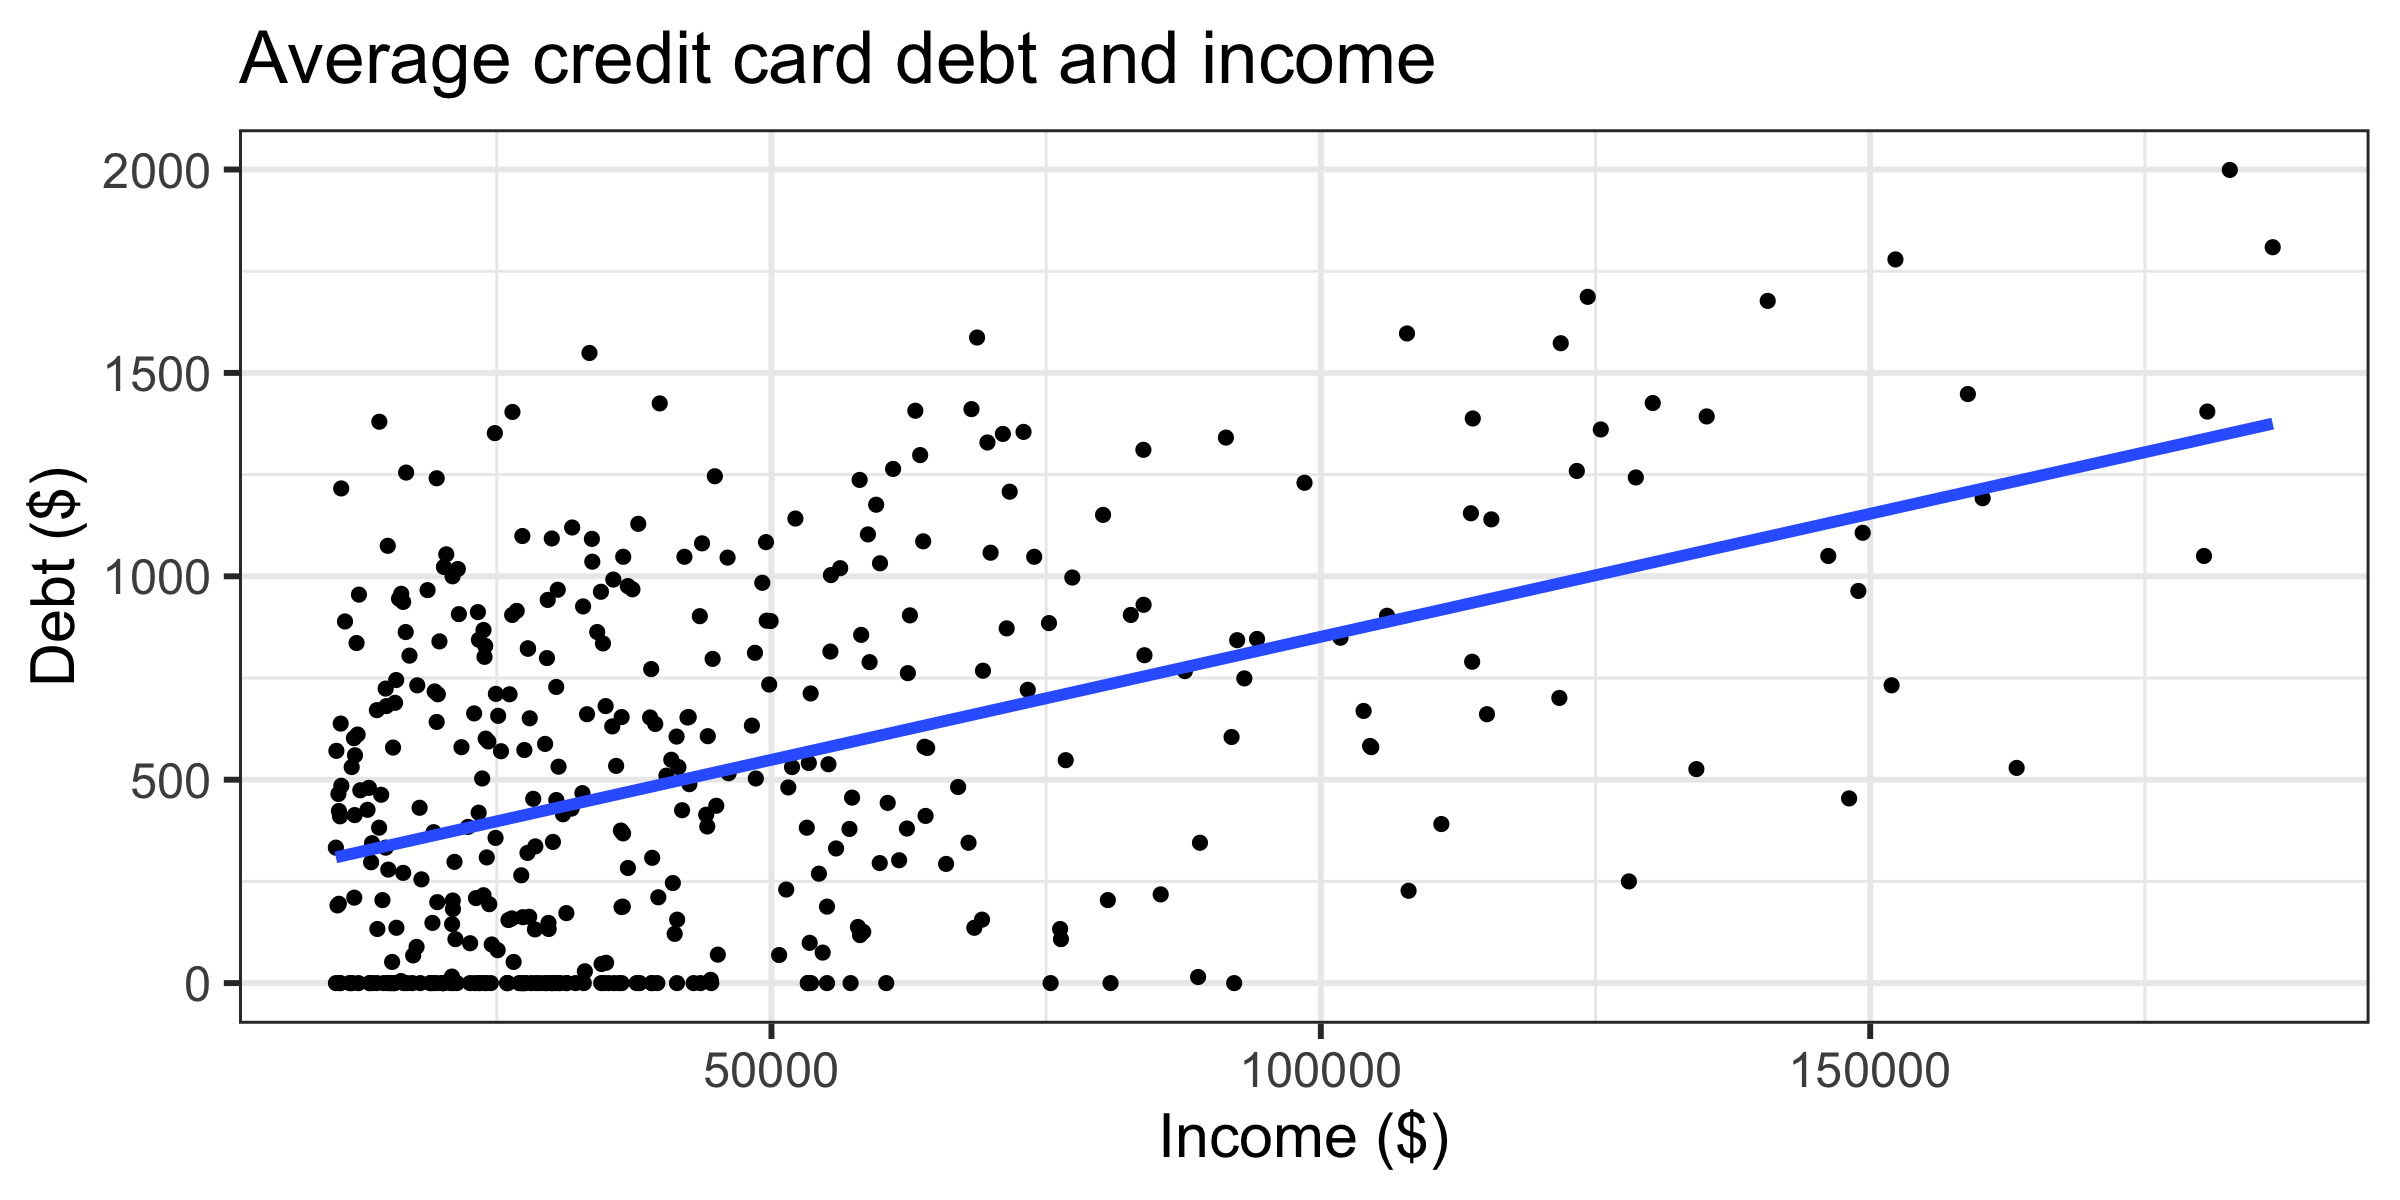

In [2]:
plot_debt_income <- ggplot(data, aes(y = debt, x = income)) +
  geom_point(size = 0.7) +
  theme_classic() +
  theme +
  labs(x = "Income ($)", y = "Debt ($)")

plot_debt_income + geom_smooth(method = "lm", se = FALSE, formula = y ~ x) +
  labs(title = "Average credit card debt and income")

#### You Try 1: Simple Linear Regression (3 mins)

Tasks: 

A. Regress credit card `debt` on `income`.

B. Report the regression table: $\beta$ and test statistic values of the intercept and income explanatory variables.

C. Report the fit summary: $R$, $R^2$, `nobs`, and the test statistic values

D. Comment on the results and interpret them.

In [10]:
# Task 1A

lm_income <- lm(debt ~ income, data)

In [11]:
# Task 1B

regression_table(lm_income)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,246.515,7.425
income,0.006,10.440


In [12]:
# Task 1C

fit_summary(lm_income)

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.464,0.215,400,108.992


##### Task 1D: Interpretation

$R = 0.464 $ - Strength of the linear relationship between two variables.

$R^2 = 0.215 $ -  Proportion of the variance in the response variable that can be explained by the explanatory variables in the regression model.

### You Try 2: Guess the correlation (3 mins)

Tasks:

A. Look at the random display of data.

B. Guess the correlation $R$!

In [8]:
library(IRdisplay)
display_html('<iframe src="http://guessthecorrelation.com" width="500" height="550" frameBorder="0"></iframe>')

### Multiple Linear Regression: credit `debt` regressed on `income` and credit `limit`

> $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_2\textrm{limit}$

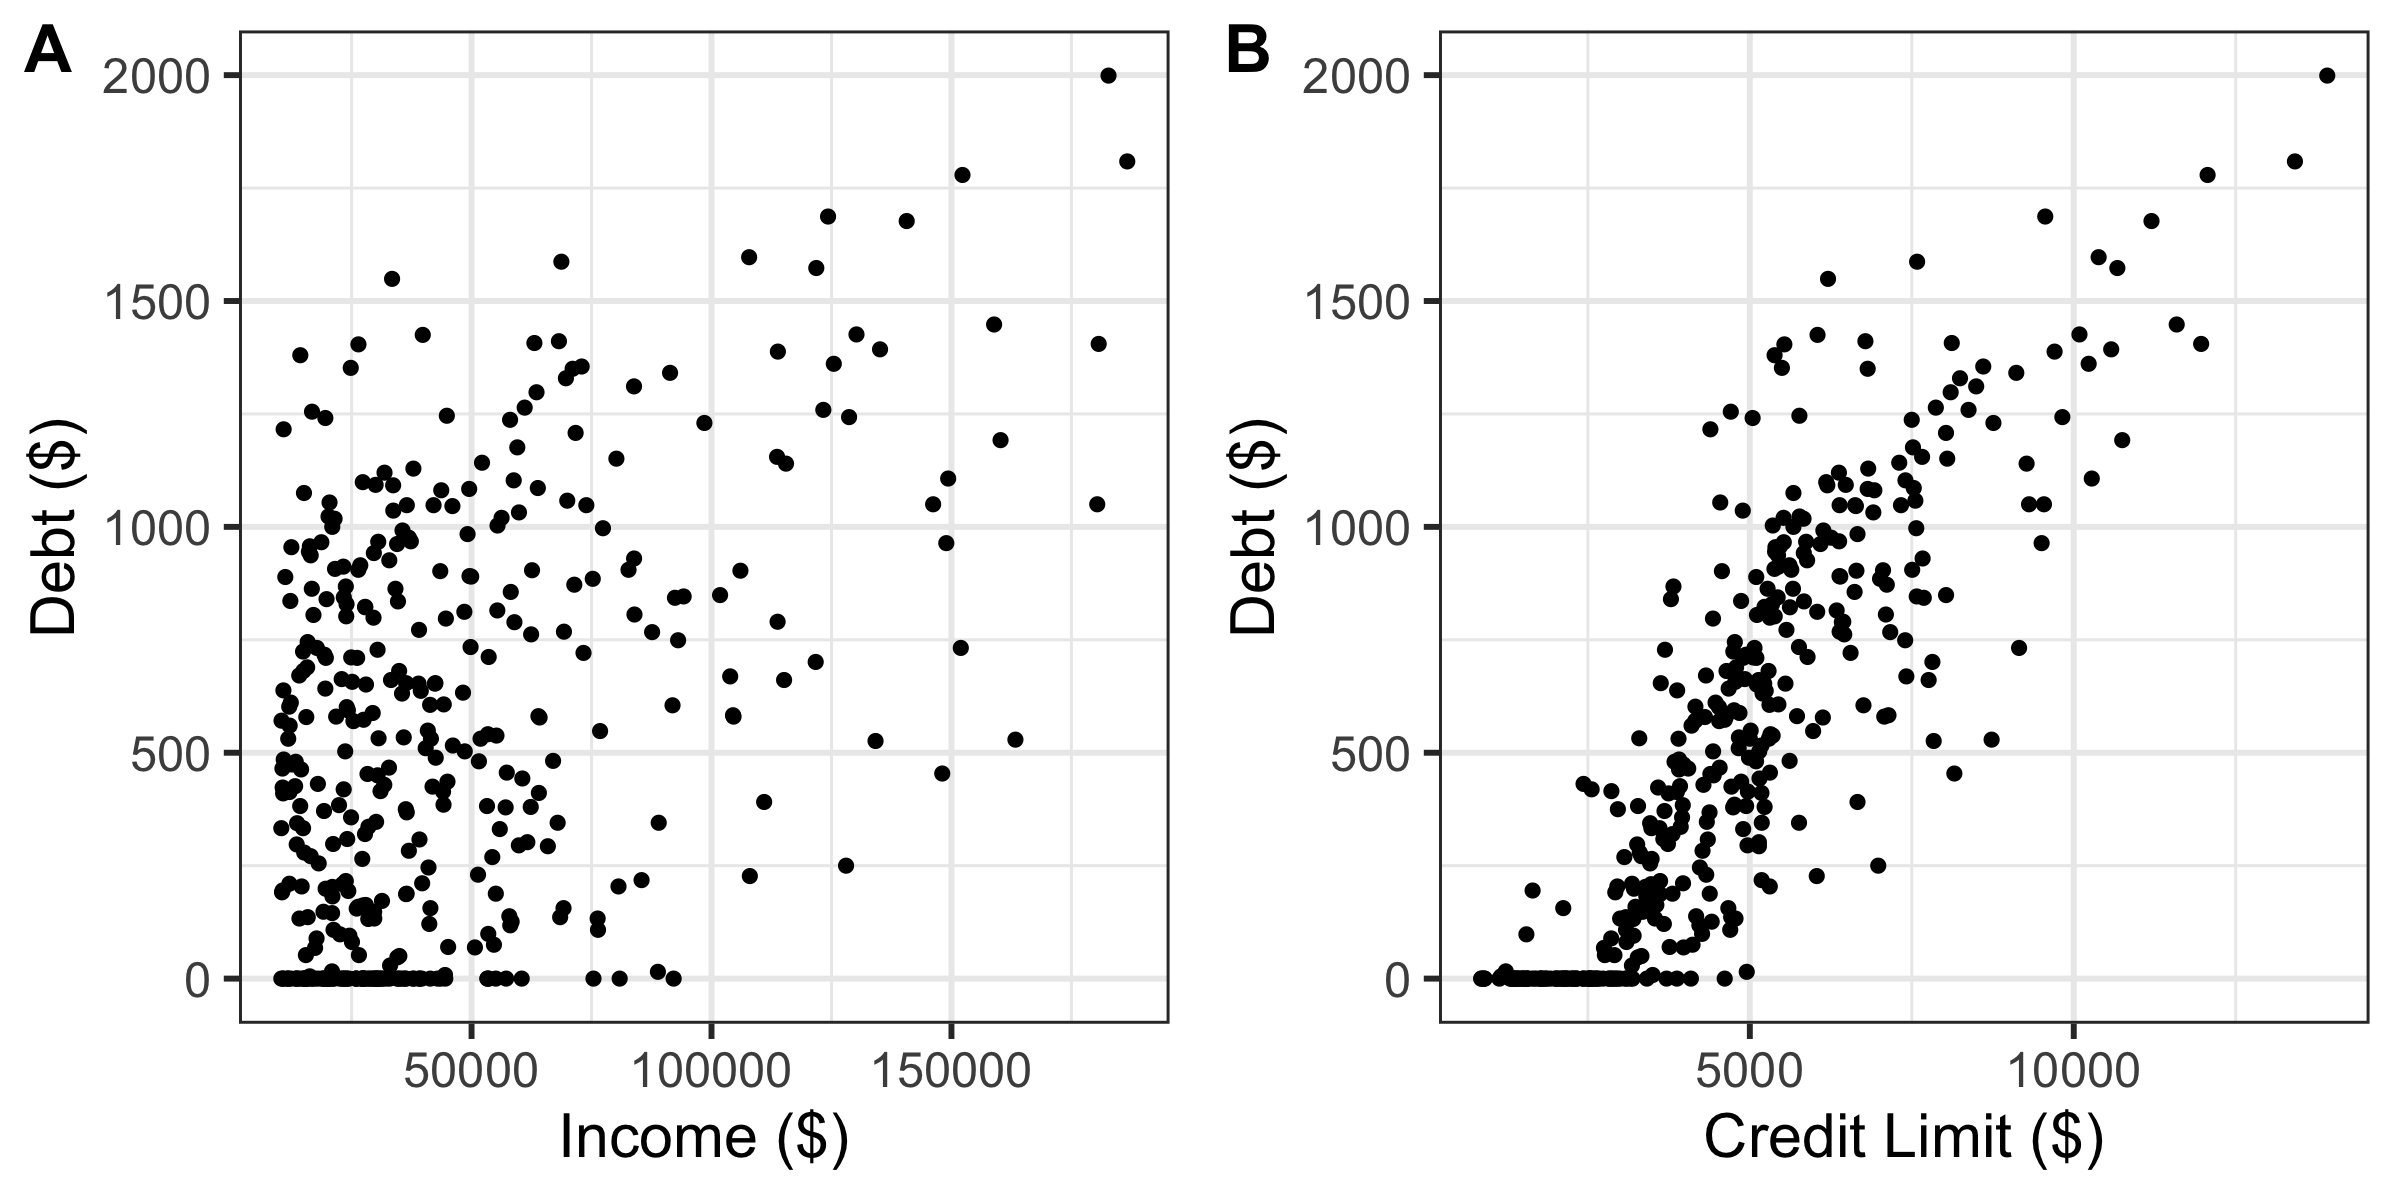

In [13]:
plot_debt_limit <- ggplot(data, aes(y = debt, x = limit)) +
  geom_point(size = 0.7) +
  theme_classic() +
  theme +
  labs(x = "Credit Limit ($)", y = "Debt ($)")

plot_grid(plot_debt_income, plot_debt_limit, labels = c("A", "B"), label_size = 12)

#### You Try 3: Multiple Linear Regression (2 mins)

Tasks: 

A. Regress credit card `debt` on `income` and `limit`

B. Report the regression table: $\beta$ and test statistic values of the intercept and income explanatory variables.

C. Report the fit summary: $R$, $R^2$, `nobs`, and the test statistic values

D. Comment on the results and interpret them.

In [20]:
# Task 3A

lm_income_limit <- lm(debt ~ income + limit, data)

In [21]:
# Task 3B

regression_table(lm_income_limit)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-385.179,-19.789
income,-0.008,-19.901
limit,0.264,44.955


In [22]:
# Task 3C

fit_summary(lm_income_limit)

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.933,0.871,400,1341.536


##### Task 3D: Interpretation

$R = 0.933 $ - Strength of the linear relationship between two variables. (Not appropriate for multiple linear regression)

$R^2 = 0.871 $ -  The proportion of the variance in the response variable that can be explained by the explanatory variables in the regression model.

### Summary so far...

- `income` does not explain much of the variance in the `debt`
    - $R^2 = 0.215$

- Adding credit `limit` to the equation does help explain a lot more of the variance in `debt`
    - $R^2 = 0.871$



## Checking the stability of a regression (5 mins)

**CQ1: Make a prediction**: With the same data, if we run the regression 5 times on the same explanatory variables, will we get the same $\beta$-coefficients ?

> A. Re-doing the regression will always return **the same** $\beta$-coefficients.
>
> B. Re-doing the regression will always return **different** $\beta$-coefficients.
>
> C. It depends on the conditions under which the regression was done.
>
> D. I don't know.

### Running the same regression repeatedly

**Let's check:**

In [29]:
lm_income_limit <- lm(debt ~ income + limit, data)
regression_table(lm_income_limit)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-385.179,-19.789
income,-0.008,-19.901
limit,0.264,44.955


**CQ2: Make a prediction**: Will the $\beta$-coefficients change if we add an explanatory variable that is randomly distributed, `random` and has no correlation with the response variable, $\hat{debt}$ ?

> $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_2\textrm{limit} + \beta_r\textrm{random}$


> A. Doing the regression with `random` **will not change** the $\beta$-coefficients.
>
> B. Doing the regression with `random` **will change** the $\beta$-coefficients.
>
> C. I don't know.

[1] -0.027


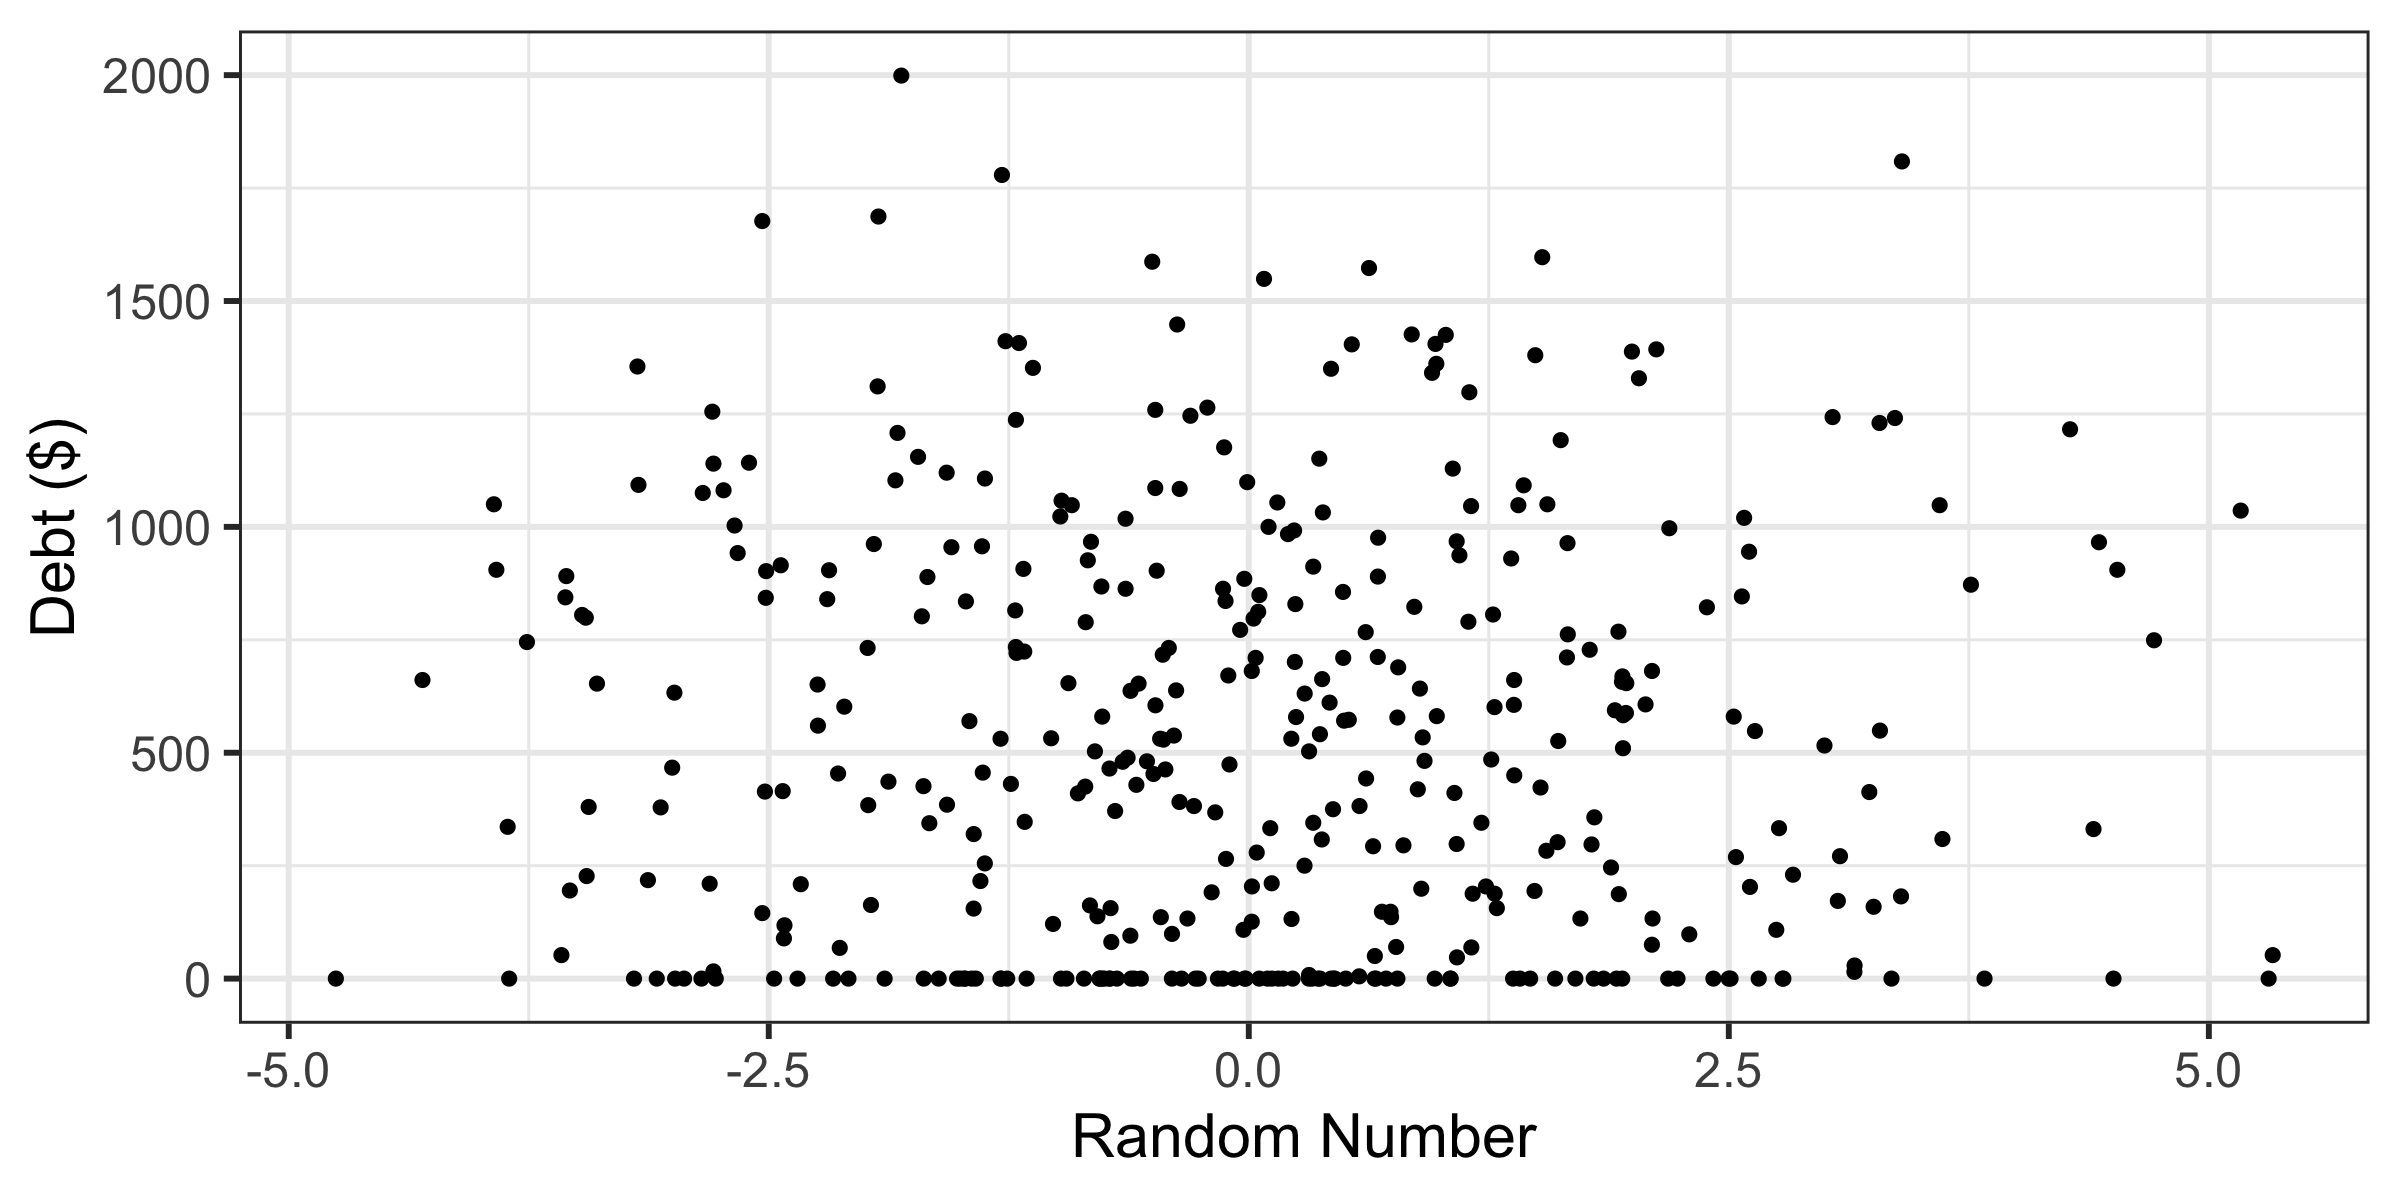

In [31]:
# Visualize the random variable

data_random <- data |>
  add_column(random = rnorm(length(data$limit), mean = 0, sd = 2))

# Plot the debt vs. random variable

plot3 <- ggplot(data_random, aes(y = debt, x = random)) +
  geom_point(size = 0.7) +
  theme_classic() +
  theme +
  labs(x = "Random Number", y = "Debt ($)")

plot3

print(round(cor(data_random$random, data_random$debt), 3))

### Comparing the regression with `random` variable and the original

**Let's check:**

In [32]:
lm_income_limit_random <- lm(debt ~ income + limit + random, data_random)
regression_table(lm_income_limit_random)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-384.965,-19.771
income,-0.008,-19.864
limit,0.264,44.913
random,-3.963,-0.900


**Recall:**

In [33]:
lm_income_limit <- lm(debt ~ income + limit, data)
regression_table(lm_income_limit)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-385.179,-19.789
income,-0.008,-19.901
limit,0.264,44.955


### Summary so far...

- Conceptually, it should make sense that adding a "random" explanatory variable to our regression should have very little effect on either inference or prediction.
    - What if the mean wasn't 0, and/or if the standard deviation was huge?
        - Try it and explore: `rnorm(length(data$limit), mean = 0, sd = 2))`

- Adding a column of random numbers **does not** seem to alter the $\beta$-coefficients very much... 
    - this indicates some *stability* in the regression.

## Introduction to Collinearity (15 mins)

In today's class we will discuss the problem of multicolinearity in linear regression.

### What if two explanatory variables in our linear model were correlated?

**CQ3: Make a prediction**: Should we be concerned if some of our explanatory variables were correlated? Why or Why not?


> A. Yes.
>
> B. No.
>
> C. I don't know.

### How would we check to see if two variables were correlated?
- Hint: You already know how to do this!

#### Is credit `rating` is correlated with `limit` ?

**Let's Check!**

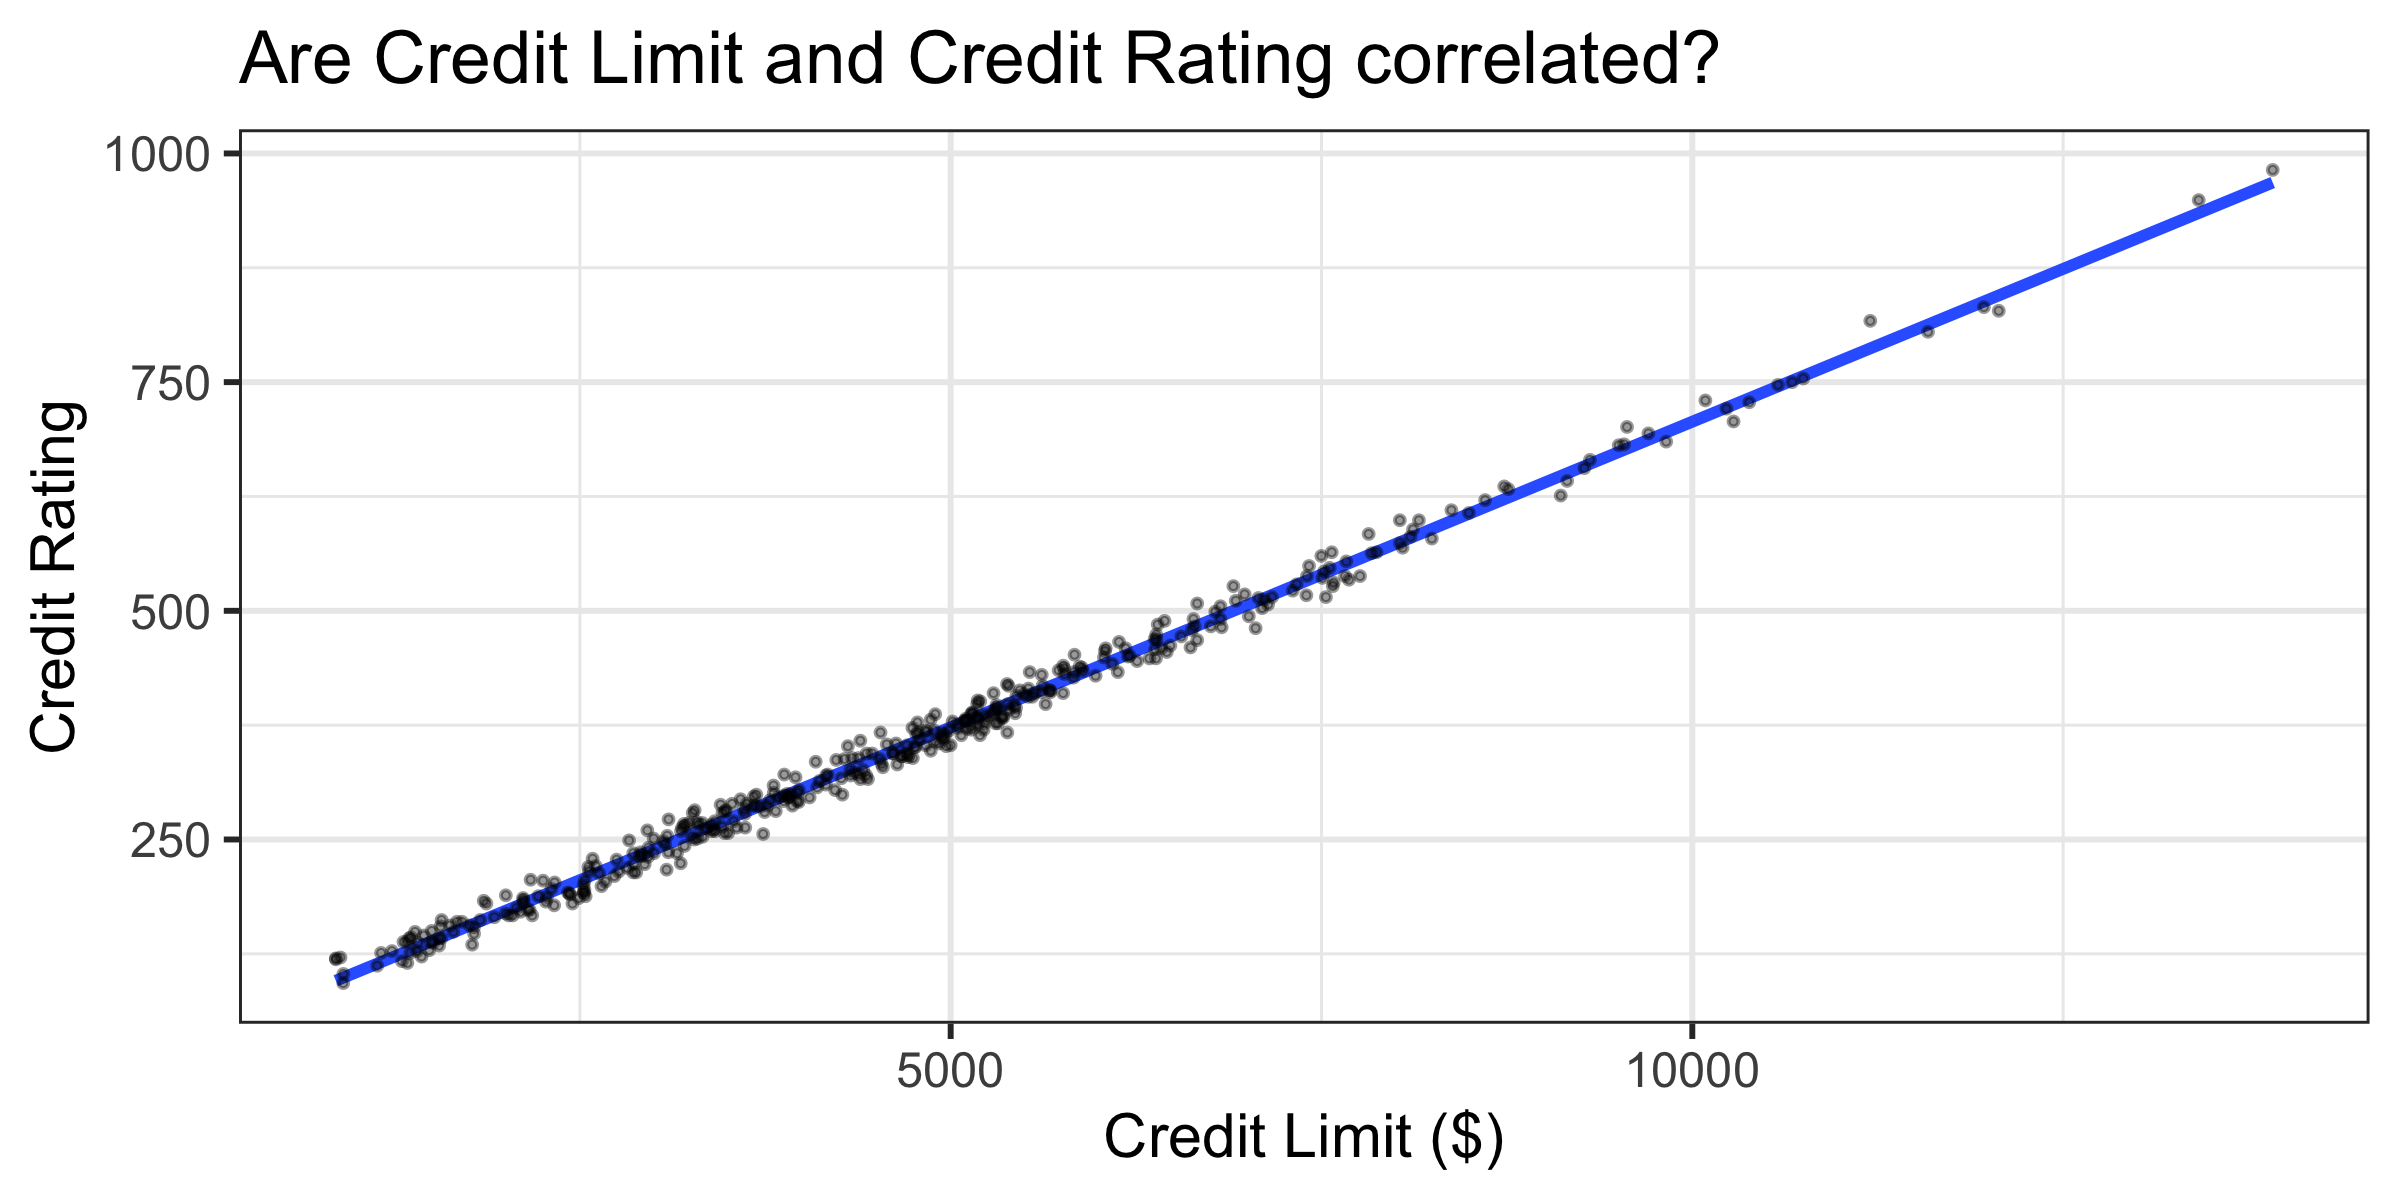

In [105]:
plot_rating_limit <- ggplot(data, aes(y = rating, x = limit)) +
  theme_classic() +
  theme +
  labs(x = "Credit Limit ($)", y = "Credit Rating", title = "Are Credit Limit and Credit Rating correlated?") +
  geom_smooth(method = "lm", se = FALSE, formula = y ~ x) +
  geom_point(size = 0.5, alpha = 0.4)

plot_rating_limit

In [34]:
lm_rating_limit <- lm(rating ~ limit, data)
fit_summary(lm_rating_limit)

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.997,0.994,400,63478.33


##### Interpretation

$R = 0.997 $ ; Strength of the linear relationship between two variables.

$R^2 = 0.994 $ ; The proportion of the variance in the response variable that can be explained by the explanatory variables in the regression model.

#### Key Point

- Linear Regression is just a tool in your toolkit!
- The `response` variables and `explanatory` variables can be different depending on what your **research question** is
- There's nothing magical about this...

#### Aside: Visualizing correlations between variables

There was a question on our discussion forum yesterday about the best way to visualize correlations.

- There are many options and packages for visualizing correlations!

- All of them rely on computing the correlation coefficient $R$.
    - Recall: the [`cor()`](https://rdrr.io/github/PROMiDAT/RSDA/man/cor.html) function is useful to calculate $R$.
    
- Please feel free to experiment and explore!
    - But remember the Principles of Effective Data Visualizations!

##### Correlation Matrix

In [54]:
correlations <- cor(data |> select(where(is.numeric)))
round(correlations, 2)

,id,income,limit,rating,cards,age,education,debt
id,1.00,0.04,0.02,0.02,-0.04,0.06,0.00,0.01
income,0.04,1.00,0.79,0.79,-0.02,0.18,-0.03,0.46
limit,0.02,0.79,1.00,1.00,0.01,0.10,-0.02,0.86
rating,0.02,0.79,1.00,1.00,0.05,0.10,-0.03,0.86
cards,-0.04,-0.02,0.01,0.05,1.00,0.04,-0.05,0.09
age,0.06,0.18,0.10,0.10,0.04,1.00,0.00,0.00
education,0.00,-0.03,-0.02,-0.03,-0.05,0.00,1.00,-0.01
debt,0.01,0.46,0.86,0.86,0.09,0.00,-0.01,1.00


##### Corellogram

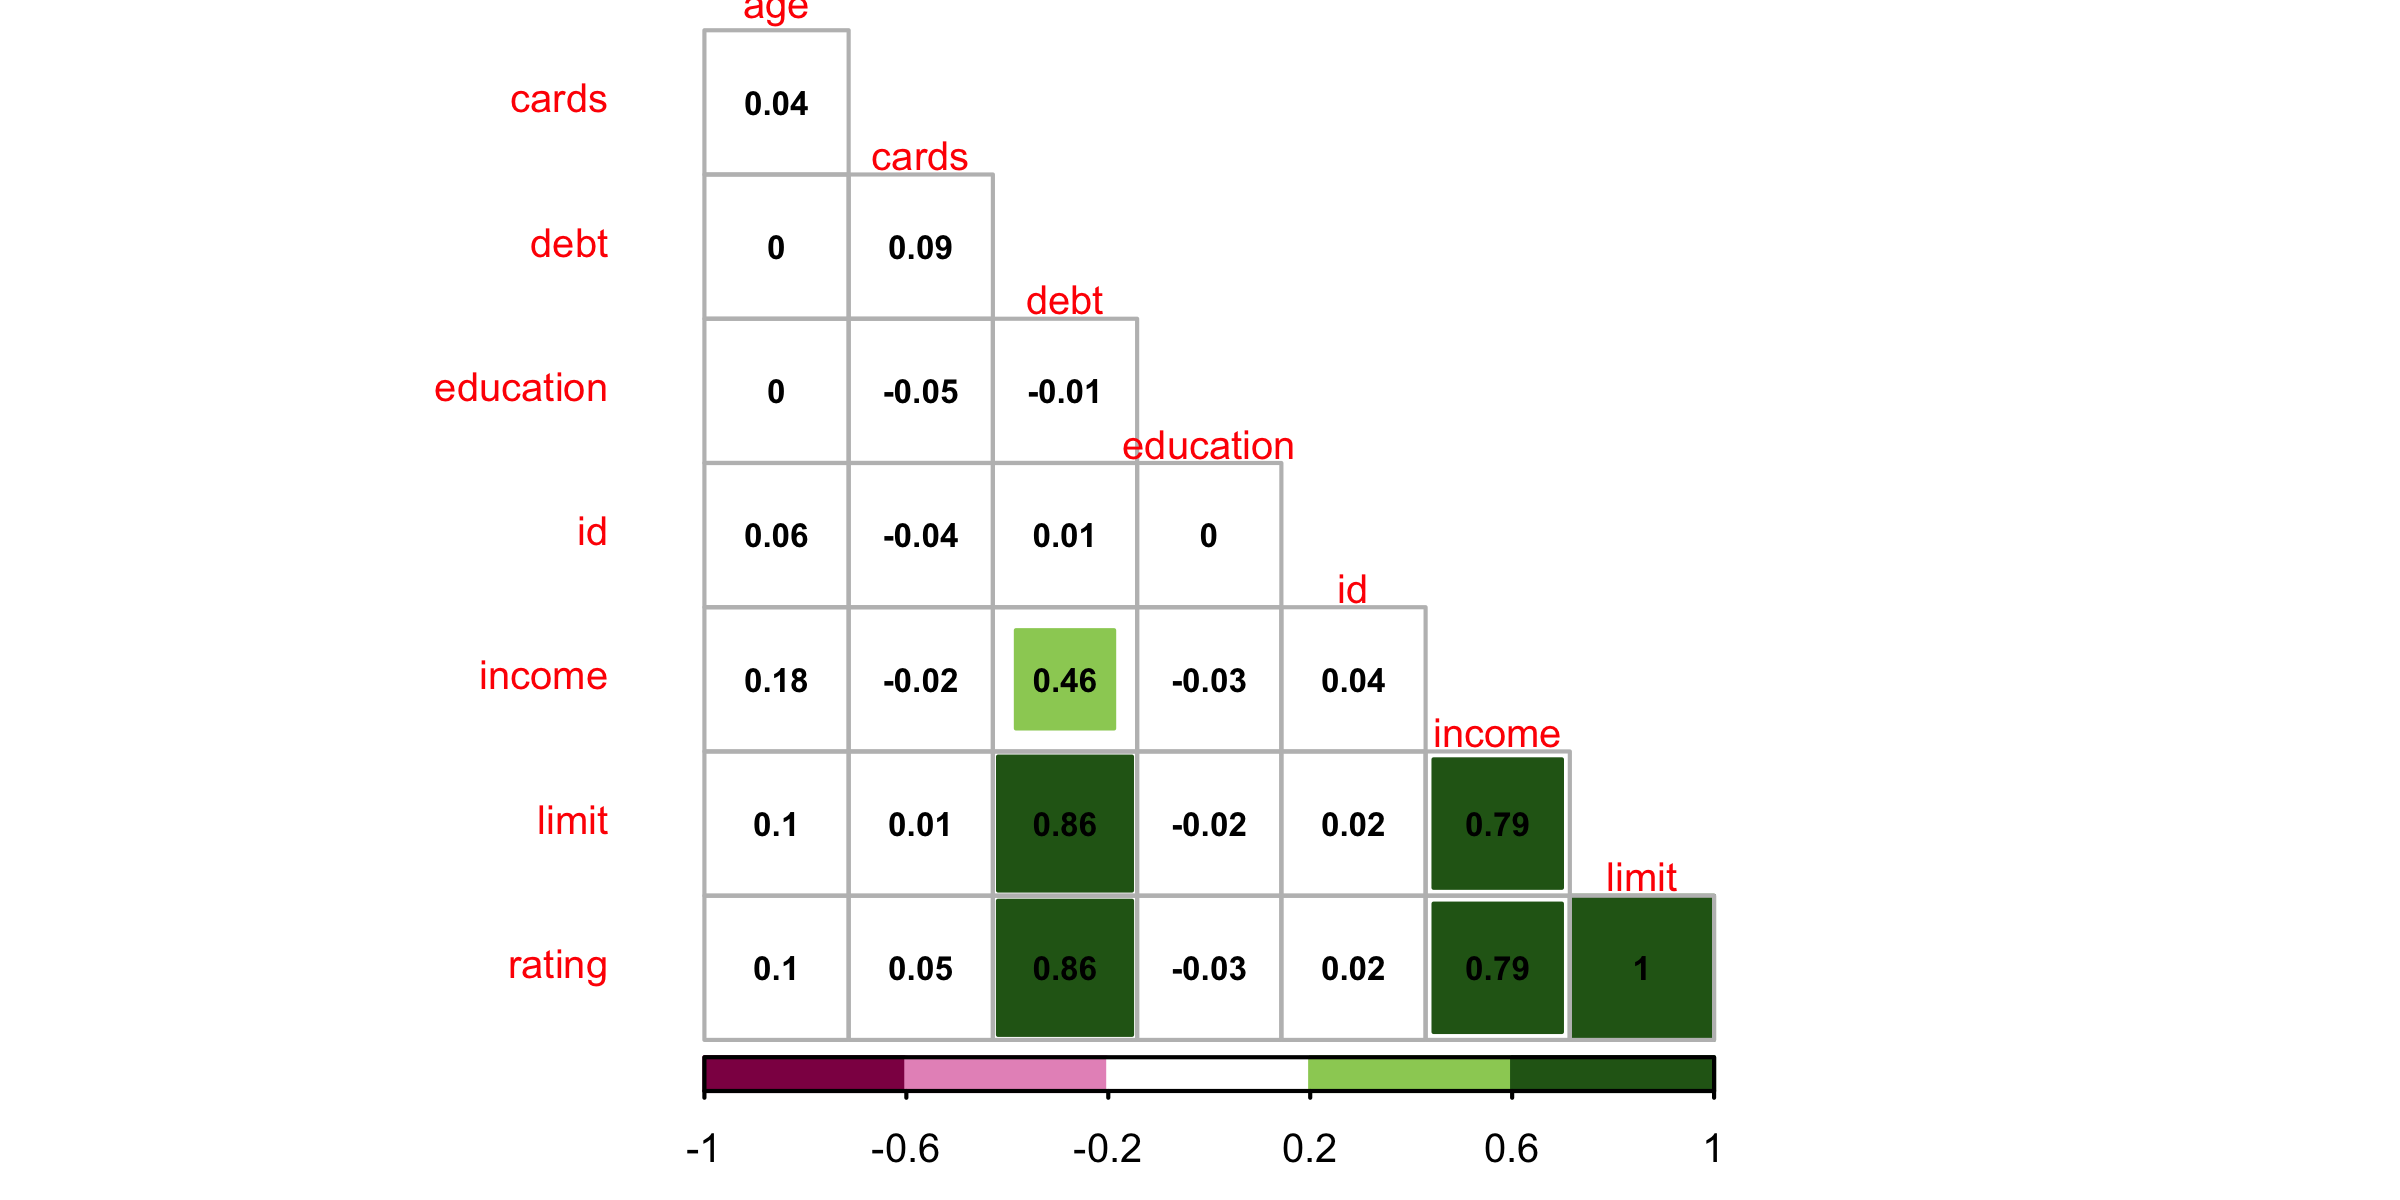

In [24]:
corrplot(correlations,
  method = "square", type = "lower", diag = FALSE,
  addCoef.col = "black", number.cex = 0.5, cl.cex = 0.6, tl.cex = 0.6, tl.pos = "ld", tl.offset = 1.2,
  order = "alphabet", tl.srt = 0, col = COL2("PiYG", 5)
)

##### Pair Plot

In [35]:
# library(GGally) # This requires the GGally library

plot_pair <- ggpairs(data |> select(where(is.numeric)))

<img src="images/ggpairs.png">

### Summary so far...

- Credit `limit` and credit `rating` are almost perfectly correlated (collinear), $R=1$!

- Several ways of checking to see if variables are correlated:
    - Correlation matrices
    - Correllogram
    - Pair Plots
    
- Consider the cofficients $\beta_2$ and $\beta_3$ for credit `limit` and credit `rating` in a regression model. 


> $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_2\textrm{limit} + \beta_3\textrm{rating}$

### What is the effect (on $\beta$) of having correlated explanatory variables ?

🤔 Consider the cofficients $\beta_2$ and $\beta_3$ for credit `limit` and credit `rating` in a regression model

> $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_2\textrm{limit} + \beta_3\textrm{rating}$

- How would $\beta_2$ and $\beta_3$ be affected in a regression if `limit` and `rating` were correlated?

**Let's try it!**

- We will use the same trick as before, add a column of random numbers and see how it affects the $\beta$ values. 

In [36]:
lm_income_limit_rating <- lm(debt ~ income + limit + rating, data)
regression_table(lm_income_limit_rating)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-489.727,-15.257
income,-0.008,-20.418
limit,0.085,1.894
rating,2.699,4.052


In [37]:
# Add a column of random numbers to the `data`

data_random <- data |>
  add_column(random = rnorm(length(data$limit), mean = 0, sd = 2))

In [38]:
lm_income_limit_rating_random <- lm(debt ~ income + limit + rating + random, data_random)
regression_table(lm_income_limit_rating_random)

term,beta,statistic
<chr>,<dbl>,<dbl>
intercept,-487.346,-15.058
income,-0.008,-20.411
limit,0.088,1.950
rating,2.650,3.948
random,-2.585,-0.605


#### You Try 4: Stability of regression with collinearity (5 mins)

Tasks:

A. Run two regressions $lm_1$ and $lm_2$ with and without the `random` variable,

> $lm_1$ $\rightarrow$ $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_2\textrm{limit} + \beta_3\textrm{rating}$

> $lm_2$ $\rightarrow$ $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_2\textrm{limit} + \beta_3\textrm{rating} + \beta_4\textrm{random}$

B. Repeat this 15 times using a loop.

C. Print out the beta coefficient for the `rating` column

D. Repeat A,B,C for the following two regressions (i.e. after removing collinearity of `limit` and `rating` by dropping `rating`):

> $lm_3$ $\rightarrow$ $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_3\textrm{limit}$

> $lm_4$ $\rightarrow$ $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_3\textrm{limit} + \beta_4\textrm{random}$



Expected output:

```
[1] beta_3(lm_1) beta_3(lm_2)
[1] beta_3(lm_1) beta_3(lm_2)
[1] beta_3(lm_1) beta_3(lm_2)
[1] beta_3(lm_1) beta_3(lm_2)
...
```

In [113]:
# Task 4A, 4B, 4C

for (k in 1:15) {
  data_random <- data |>
    add_column(random = rnorm(length(data$limit), mean = 0, sd = 2))

  lm_1_beta3 <- regression_table(lm(debt ~ income + limit + rating, data_random))[[4, 2]]
  lm_2_beta3 <- regression_table(lm(debt ~ income + limit + rating + random, data_random))[[4, 2]]
  print(c(lm_1_beta3, lm_2_beta3))
}

[1] 2.699 2.714
[1] 2.699 2.694
[1] 2.699 2.685
[1] 2.699 2.702
[1] 2.699 2.753
[1] 2.699 2.676
[1] 2.699 2.704
[1] 2.699 2.667
[1] 2.699 2.644
[1] 2.699 2.715
[1] 2.699 2.767
[1] 2.699 2.696
[1] 2.699 2.697
[1] 2.699 2.715
[1] 2.699 2.697


In [39]:
# Task 4D

for (k in 1:15) {
  data_random <- data |>
    add_column(random = rnorm(length(data$limit), mean = 0, sd = 2))

  lm_3_beta3 <- regression_table(lm(debt ~ income + limit, data_random))[[3, 2]]
  lm_4_beta3 <- regression_table(lm(debt ~ income + limit + random, data_random))[[3, 2]]
  print(c(lm_3_beta3, lm_4_beta3))
}

[1] 0.264 0.264
[1] 0.264 0.265
[1] 0.264 0.264
[1] 0.264 0.264
[1] 0.264 0.264
[1] 0.264 0.264
[1] 0.264 0.265
[1] 0.264 0.264
[1] 0.264 0.265
[1] 0.264 0.264
[1] 0.264 0.264
[1] 0.264 0.264
[1] 0.264 0.264
[1] 0.264 0.264
[1] 0.264 0.264


### Debrief: What did you discover?

- Running the same regression with the same data, and same explanatory variables results in the same $\beta$ coefficients.

- If there is collinearity in the explanatory variables, the regression is unstable, and $\beta$ coefficients vary.

- Removing the collinearity by dropping an explanatory variable from the regression, restabilizes the $\beta$ coefficients.

#### What is the effect (on $\beta$) of having correlated explanatory variables ?

🤔 Consider the cofficients $\beta_2$ and $\beta_3$ for credit `limit` and credit `rating` in a regression model

> $\hat{debt} = \beta_0 + \beta_1\textrm{income} + \beta_2\textrm{limit} + \beta_3\textrm{rating}$

- How would $\beta_2$ and $\beta_3$ be affected in a regression if `limit` and `rating` were correlated?
    - **A: Standard error of $\beta_3$ and $\beta_4$ will increase, and small changes to the model will cause wild oscillations between larger upper and lower bounds.**
        - You should check this yourself!

### Key Point

**Revisiting CQ3: Make a prediction**: Should we be concerned if some of our explanatory variables were correlated? Why or Why not?


> A. Yes.
>
> B. No.
>
> C. I don't know.


- **A: Yes! Definitely, especially if we care about interpreting the $\beta$ coefficients (i.e. not using regression for prediction).**
    - Probably otherwise as well, more about this in your lab this week...

## What about multivariate collinearity? (5 mins)

- Unfortunately, it is also possible for collinearity to exist between three or more variables even if no single pair of variables has a particularly high correlation.

- So how can we tell if more than two variables are collinear (multicollinearity)?

- Let's formulate the question a bit more formally:
    - "Given $n$ explanatory variables $X_1, X_2, X_3, ...,X_i,... X_n$, how much of the variance in $X_i$ is explained by all other explanatory variables?"

- This sounds like we need to do another regression, and our question can be answered by computing $R^2_i$.

### Step 1: Compute $R^2_i$ 

For the explanatory variables: `income`, `limit`, `rating`, `age`:

- $X_1$ = `income`

- $X_2$ = `limit`

- $X_3$ = `rating`

- $X_4$ = `age`

The corresponding $R^2_i$s can be found by doing four separate regression analyses, and then computing $R^2$ as usual:

1. $lm$($X_1$ ~ $X_2$ + $X_3$ + $X_4$) $\rightarrow$ $R^2_{income}$

2. $lm$($X_2$ ~ $X_1$ + $X_3$ + $X_4$) $\rightarrow$ $R^2_{limit}$

3. $lm$($X_3$ ~ $X_1$ + $X_2$ + $X_4$) $\rightarrow$ $R^2_{rating}$

4. $lm$($X_4$ ~ $X_1$ + $X_2$ + $X_3$) $\rightarrow$ $R^2_{age}$

In [40]:
fit_summary(lm(income ~ limit + rating + age, data))

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.798,0.637,400,231.607


fit_summary(lm(limit ~ income + rating + age, data))e

In [42]:
fit_summary(lm(rating ~ income + limit + age, data))

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.997,0.994,400,21097.64


In [43]:
fit_summary(lm(age ~ income + rating + limit, data))

R,R^2,nobs,statistic
<dbl>,<dbl>,<dbl>,<dbl>
0.188,0.035,400,4.838


| $R^2_i$ | Value           |
| --- | --------------- |
| $R^2_{income}$ |0.637 |
| $R^2_{limit}$ | 0.994 |
| $R^2_{rating}$ | 0.994  |
| $R^2_{age}$ | 0.035 |

### Step 2: Compute the Variance Inflation Factor (VIF)

- The severity of multicollinearity can be determined for each explanatory variable, by transforming $R^2_i$ to the Variance Inflation Factor, or VIF:

\begin{equation}
\textrm{VIF}_i = \frac{1}{1-R^2_i}\textrm{, where } 0 \leq R^2_i \leq 1
\end{equation}


| Variance Inflation Factor | Value           |
| --- | --------------- |
| $\textrm{VIF}_{income}$ | 2.75 |
| $\textrm{VIF}_{limit}$ | 166.7 |
| $\textrm{VIF}_{rating}$ | 166.7  |
| $\textrm{VIF}_{age}$ | 1.04 |

#### You Try 5: Compute VIF (2 mins)

Task: 

A. Write a function to calculate VIF if provided an R^2 value

B. Verify the VIF values in the table above

In [44]:
# Task 5A:

vif <- function(R2) {
  return(round(1 / (1 - R2), 2))
}

vif(0.994)

[1] 166.67

In [45]:
# Task 5B:

vif(0.637)
vif(0.994)
vif(0.994)
vif(0.035)

[1] 2.75

[1] 166.67

[1] 166.67

[1] 1.04

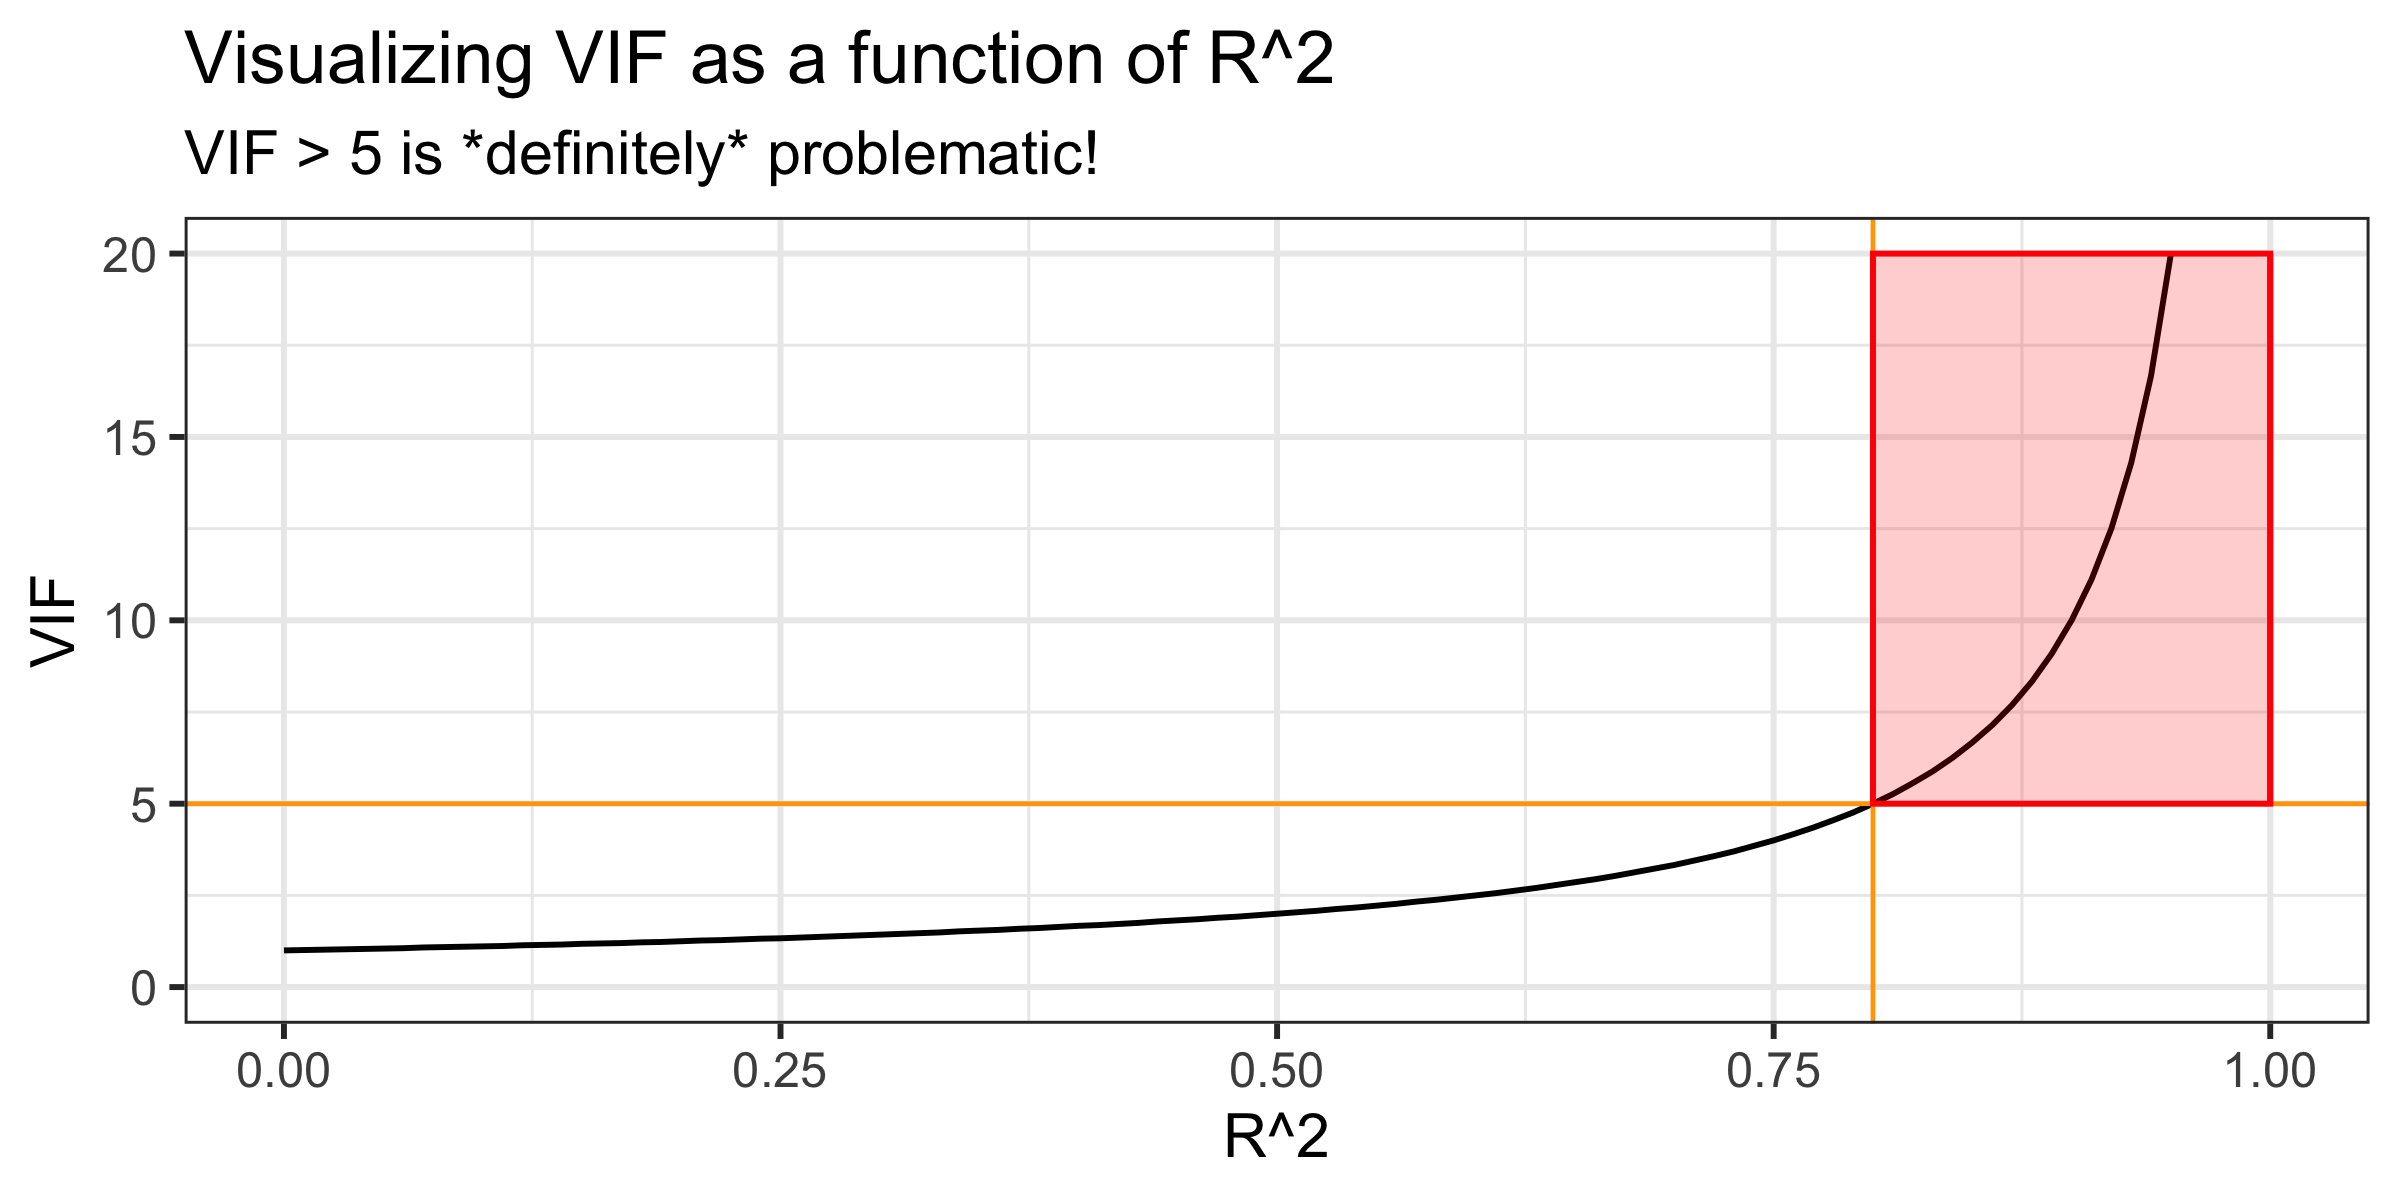

In [83]:
vif_data <- tibble(y = vif(seq(0, 95) / 100), x = seq(0, 95) / 100)

ggplot(vif_data, aes(x = x, y = y)) +
  geom_line() +
  labs(x = "R^2", y = "VIF", title = "Visualizing VIF as a function of R^2", subtitle = "VIF > 5 is *definitely* problematic!") +
  theme +
  geom_hline(yintercept = 5, color = "orange", size = 0.4) +
  geom_vline(xintercept = 0.8, color = "orange", size = 0.4) +
  annotate("rect", xmin = c(0.8, 1), xmax = c(1, 1), ymin = c(5, 5), ymax = c(20, 20), alpha = 0.2, color = "red", fill = "red") +
  ylim(0, 20)

In [46]:
# Alternate way using `car` package

round(car::vif(lm(debt ~ income + limit + rating + age, data)), 1)

# Note: the minor differences are due to rounding of R^2

income  limit rating    age 
   2.8  161.4  160.8    1.0

### Summary so far...

- To diagnose multi-collinearity, the Variance Inflation Factor (VIF) is a useful quantity:

\begin{equation}
\textrm{VIF}_i = \frac{1}{1-R^2_i}\textrm{, where } 0 \leq R^2_i \leq 1
\end{equation}

- Interpretation of a VIF value of 1.5 : 
    - The variance of that $\beta$ coefficient is 50% larger than what you'd expect if there was no multicollinearity in your regression (i.e. if explanatory variables were weakly correlated).
    
- VIF values larger than ~ 5 ($R^2 > 0.8$) will result in severe problems with the linear regression.

- But once we have identified multicollinearity, what are some strategies to address it?

## Addressing multicollinearity (2 min)

There are three main ways to deal with multicollinearity:

1. Drop one of the multicollinear variables from your regression model.

2. Combine/Transform the collinear variables into a new composite variable.

3. ~~Ignore the multicollinearity.~~
    - Only useful if you are not interested in interpreting the $\beta$ coefficients.
    - My personal opinion is to STRONGLY discourage this "solution"!!

## Recap of Learning Intentions (1 min)

After deliberate **review** of this lesson, consideration of supplementary content, and sufficient **practice**, I intend for students to be able to:

- Implement a simple linear regression, and a multiple linear regression in the R programming language.

- Develop some *intuition* about the correlation ($R$), and assess whether there is collinearity between two variables.

- Evaluate the stability of a linear regression model with and without collinearity.

- Use the Variable Inflation Factor (VIF) to determine whether multicollinearity exists in a regression analysis.

- Critically examine strategies for resolving multicollinearity in regression analyses (**focus of the lab**).

See you in the lab!

## Introducing Lab Question (3 mins)

In the lab questions, you will explore the three ways of addressing multicollinearity and reflect on some of the intuition you've developed with linear regression.